In [1]:
import sys
sys.path
sys.path.append('../service/')

print(sys.executable)

/home/stefan/coding/notebooks/env/bin/python


In [3]:
# standart libs
import random
import copy

# 3rd party libs
import pandas as pd
import numpy as np
import gempy as gp
import matplotlib.pyplot as plt

# local
import functions as fun

# Init

In [4]:
# instantiate the geo_model
geo_model = gp.create_model("BaseModel")

# defautl data
geo_model = gp.init_data(
    geo_model,
    extent=[0, 1, 0, 1, 0, 1],
    resolution=[5, 5, 5]
)

# compile theno function
gp.set_interpolation_data(
    geo_model,
    compile_theano=True,
    theano_optimizer='fast_run',
)

Active grids: ['regular']
Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_run
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                     values
range              1.73205
$C_o$            0.0714286
drift equations        [3]


# Model 1

## Data

In [5]:
# meta
geo_model_extent = [0,1000,0,1000,0,1000]
section = {
    'p1': [0, 500],
    'p2': [1000, 500],
    'resolution': [200, 200]
}

# sereis
series_df = pd.DataFrame(columns=['name', 'isfault', 'order_series'])
series_df.loc[0] = { 'order_series': 0, 'name': 'Basement_Series', 'isfault': False }
series_df.loc[1] = { 'order_series': 1, 'name': 'Strat_Series', 'isfault': False }

# surfaces
surfaces_df = pd.DataFrame(columns=['name', 'serie', 'order_surface'])
surfaces_df.loc[0] = { 'name': 'basement', 'serie': 'Basement_Series', 'order_surface': 0 }
surfaces_df.loc[2] = { 'name': 'rock1', 'serie': 'Strat_Series', 'order_surface': 1 }
surfaces_df.loc[1] = { 'name': 'rock2', 'serie': 'Strat_Series', 'order_surface': 2 }

In [7]:
# geoData
surface_points_input_data = pd.read_csv('./data/model2_surface_points.csv')
orientaions_input_data = pd.read_csv('./data/model2_orientations.csv')

# Format geological_input_data
surface_points_original_df = surface_points_input_data[['X', 'Y', 'Z', 'formation']]

# rename colums
surface_points_original_df.columns = ['X', 'Y', 'Z', 'surface']

# add distribution type and parameter
surface_points_original_df['param1'] = 10

# Orientaions
orientations_original_df = orientaions_input_data[['X', 'Y', 'Z', 'dip', 'azimuth', 'polarity', 'formation']]

In [8]:
# maping object
surfaces_df.sort_values(by=['order_surface'])
mapping_object = {}
for index, row in series_df.iterrows():
    
    series_name = row['name']
    categories = surfaces_df[surfaces_df['serie'] == series_name]['name'].astype('category')
    mapping_object[series_name] = categories

## Set model

In [9]:
# Set meta data
gp.init_data(
    geo_model,
    extent=[0, 1000, 0, 1000, 0, 1000],
    resolution=[5, 5, 5])

# Set section grid
section_dict = {'section': (
    section['p1'],
    section['p2'],
    section['resolution']
)}
# geo_model.grid.set_inactive('regular')
geo_model.set_section_grid(section_dict=section_dict)

# Set series and surfaces
fun.update_series(geo_model, series_df)
fun.update_surfaces(geo_model, surfaces_df)

# Set surface points and orientations
geo_model.set_surface_points(surface_points_original_df, update_surfaces=False)
geo_model.set_orientations(orientations_original_df, update_surfaces=False)

# Map series to surfaces
gp.map_series_to_surfaces(
    geo_model=geo_model,
    mapping_object=mapping_object
)

# Set faults if any
if np.any(series_df['isfault']):

    fault_series = series_df[series_df['isfault']]['name']
    geo_model.set_is_fault(fault_series)

# Update to interpolator
geo_model.update_to_interpolator()

Active grids: ['regular']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
HOTFIX in update_surfaces()


True

# compute solution

In [10]:
solution = gp.compute_model(model=geo_model, sort_surfaces=False)

/home/stefan/coding/notebooks/env/lib/python3.8/site-packages/gempy/core/solution.py:196: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  vertices, simplices, normals, values = measure.marching_cubes_lewiner(


# postprocessing

## get boolen matrix

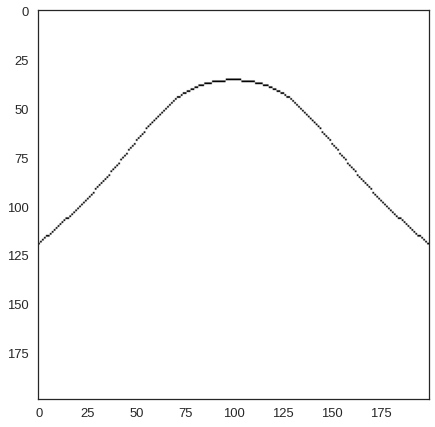

In [11]:
# get shape of section and test if consistent with our confiuration
section_shape = geo_model.grid.sections.resolution[0]

# get scalar field values
section_scalar_field_values = geo_model.solutions.sections[1]

# get scalar field level boundaries seperating lithologies
level = geo_model.solutions.scalar_field_at_surface_points[0]

# reshape 1D NpArray to original section shape
section_scalar_field_values_reshaped = section_scalar_field_values[0,:].reshape(section_shape).T

# find values bigger then level value x
bigger_level_0 = section_scalar_field_values_reshaped > level[1]

# use matrix shifting along x0axis to find top-surface
bigger_level_0_0 = bigger_level_0[1:,:]
bigger_level_0_1 = bigger_level_0[:-1,:]
bigger_level_0_i = bigger_level_0_0 ^ bigger_level_0_1

# plot
plt.imshow(bigger_level_0_i[::-1,:])
plt.show()

## calculate section coordinates

In [12]:
# destructure
p1 = np.array(section['p1'])
p2 = np.array(section['p2'])
resolution = np.array(section['resolution'])

# euclidean distance
dist = np.sqrt(
    np.diff((p1[0], p2[0])) ** 2
    + np.diff((p1[1], p2[1])) ** 2
)

# vector pointing from p1 to p2
vector_p1_p2 = p2 - p1

# normalizae vector
vector_p1_p2_normalizaed = vector_p1_p2 / np.linalg.norm(vector_p1_p2)

# steps on line between points
steps = np.linspace(0, dist, resolution[0])

# calculate xy-coordinates on line between p1 and p2
xy_coord_on_line_p1_p2 = p1.reshape(2, 1) + vector_p1_p2_normalizaed.reshape(2, 1) * steps.ravel()

# destructure
xvals = xy_coord_on_line_p1_p2[0]
yvals = xy_coord_on_line_p1_p2[1]

# stretching whole extent
zvals = np.linspace(0, 1000, resolution[1])

# meshgrids to get grid coordinates
X, Z = np.meshgrid(xvals, zvals)
Y, Z = np.meshgrid(yvals, zvals)

## apply boolean matrix to extract suface points

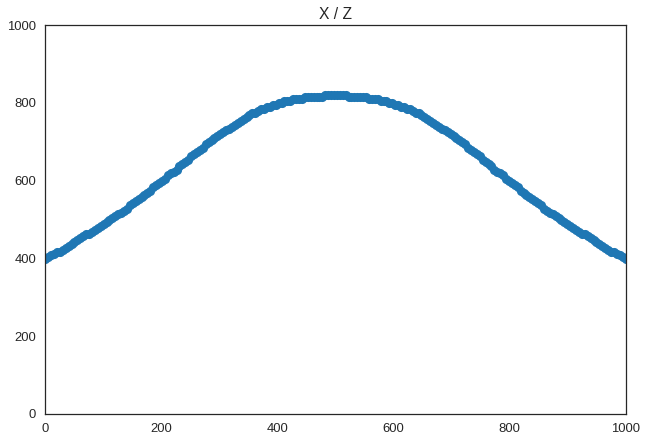

In [14]:
fig, (ax1) = plt.subplots(1, 1)
ax1.plot(X[:-1,:][bigger_level_0_i].flatten(), Z[:-1,:][bigger_level_0_i].flatten(), 'o')
ax1.set_title('X / Z')
ax1.set_xlim(0,1000)
ax1.set_ylim(0,1000)
plt.show()